# Produccion eléctrica en base a la metereología

La idea principal del trabajo es ser capaces de predecir como va a afectar a la produccion eléctrica de energias renovables y no renovables las precipitaciones, el viento y las horas de sol.
Como las horas de sol y el viento son fenomenos cuya causa efecto en principio es prácticamente inmediato, también vamos a centrarnos en la produccion de energia hidroelectrica para poder medir cuanto tiempo tarda en afectar a este tipo de energía las precipitaciones..

En base a esto tenemos varias cuestiones que queremos despejar:
- Que relación hay entre precipitaciones y el aumento de la generación de energia eléctrica hidráulica.
- Que relación hay entre horas de sol, temperatura y el aumento de la generación de energia eléctrica sólar.
- Que relación hay entre viento y el aumento de la generación de energia eléctrica eólica, esta relación esta condicionada por la temperatura, percipitaciones o horas de sol.
- Cuantos días tarda en aumentar la generación eléctrica de fuentes de energía renovables en función de los fenomenos metereológicos.
- Dados una prediccion meteorologica que valores de generación eléctrica tendremos para una fecha determinada.



Como premisas partimos de :
- Vamos a considerar solo el poll de energia que proporciona Red Electrica de España (REE)
- Vamos a considerar que las empresas no trabajan bajo mala praxis y que intentan optimizar el uso de energias renovables.
- Debido a la falta de datos a nivel diario de REE por provincia o comunidades autonomas, voy a centrar el analisis a nivel de sistema eléctrico (Peninsula, Baleares, Canarias ,Ceuta y Melilla).

Como origenes de datos para el estudio vamos a utilizar los datos proporcionados por:
- Información de REE (https://www.ree.es/es/apidatos) obtenida mediante su API.
- Datos proporcionados por aemet(https://opendata.aemet.es/centrodedescargas/inicio), vamos a utilizar la libreria  aemet desarrollada por Pablo Moreno (https://pypi.org/project/python-aemet/).

Requisitos para la ejecución del notebook:

Como requisitos para la ejecución del proyecto es necesario la instalación de la libreria python Aemet(pip install python-aemet) e instalar la libreria request.

Además las versiones de cada libreria utilizada en este proyecto son:

El modelo ha utilizar al tratarse de una prediccion númerica y no de obtener una etiqueta, sera una regresión.
Para poder llevar a cabo esa regresion se han pasado los valores de fechas a númericos, y se ha creado una columna por cada tipo de energia, creando varias variables objetivo.



In [51]:
# If the code is executed from Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/TFM_Generacion_electrica_AEMET/Python

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/TFM_Generacion_electrica_AEMET/Python'
/content/drive/My Drive/TFM_Generacion_electrica_AEMET/Python


In [52]:
# Instalacion libreria AEMET para ingesta de datos
!pip install python-aemet

In [53]:
from Lectura_AEMET_REE import Ingestion_AEMET,Ingestion_REE
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

Ing_AEMET=Ingestion_AEMET()

Ing_REE=Ingestion_REE()

pd.options.display.max_columns=None
plt.style.use('ggplot')



In [54]:
# put this in an input sentence
date_ini="2016-01-01T00:00:00UTC"
date_end="2021-12-31T00:00:00UTC"

# 1- Read data from API and CSV

###  Lectura datos AEMET <a id='From_api'></a>

Para la lectura de datos metereólogicos, vamos a utilizar la libreria aemet, de la que utilizaremos los metodos de las clases Aemet y Estacion para obtener los datos a nivel diario de cada estación meterologica para un rago de fechas, de las provincias que nos interesan para el estudio.<a id='From_api'></a>

In [55]:
df_weather=Ing_AEMET.read_weather_dates(date_ini,date_end)

Reading list of id of weather stations...



Reading AEMET data from 2016-01-01T00:00:00UTC to 2016-12-31T00:00:00UTC ...



Reading AEMET data from 2017-01-01T00:00:00UTC to 2017-12-31T00:00:00UTC ...



Reading AEMET data from 2018-01-01T00:00:00UTC to 2018-12-31T00:00:00UTC ...



Reading AEMET data from 2019-01-01T00:00:00UTC to 2019-12-31T00:00:00UTC ...



Reading AEMET data from 2020-01-01T00:00:00UTC to 2020-12-31T00:00:00UTC ...



Reading AEMET data from 2021-01-01T00:00:00UTC to 2021-12-31T00:00:00UTC ...



Finish reading AEMET date from 2016-01-01 to 2021-05-20


### Lectura de los datos de REE

Para la lectura de los datos de REE voy a utilizar la libreria python requests para a traves de su API, obtener la generación de electricidad en , para cada tipo de energia Electrica.

Una vez leidos los datos de la API, guardo los datos en formato json en un fichero. para no tener que repetir las consultas y poder trabajar sin conexion.

La estrutura de los datos leidos de REE es la siguiente:


Por lo que vamos a almacenar 2 ficheros:
    - Renovables
    - No Renovables



In [56]:
df_ree=Ing_REE.read_ree_dates(date_ini,date_end)

## Other data

https://datos.gob.es/en/catalogo/l01280796-calendario-laboral

In [57]:
df_holidays=pd.read_csv(Ing_AEMET.path_Data+'calendario.csv',
                        sep=';',
                        encoding = 'latin-1',
                        usecols=['Dia','Tipo de Festivo'],
                        dtype=str)
df_holidays['Holiday']=(df_holidays['Tipo de Festivo']=='Festivo nacional').astype(np.int)
df_holidays['Dia']=pd.to_datetime(df_holidays['Dia'])

df_holidays.drop(columns='Tipo de Festivo',inplace=True)
df_holidays.dropna(inplace=True)

In [58]:
df_weather['fecha']=pd.to_datetime(df_weather['fecha'])
df_weather=df_weather.merge(df_holidays,how='left',left_on='fecha',right_on='Dia')
df_weather['weekday']=df_weather['Dia'].dt.dayofweek
df_weather.drop(columns='Dia',inplace=True)

In [59]:
df_weather.head()

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin,Holiday,weekday
0,2016-01-01,0252D,ARENYS DE MAR,BARCELONA,74,"11,2","0,2","7,8",06:20,"14,7",12:40,24,"1,7","7,2",14:00,NaN,NaN,NaN,NaN,NaN,1,4
1,2016-01-02,0252D,ARENYS DE MAR,BARCELONA,74,"11,8","0,0","7,5",23:40,"16,1",13:10,24,"1,1","9,7",11:40,NaN,NaN,NaN,NaN,NaN,0,5
2,2016-01-03,0252D,ARENYS DE MAR,BARCELONA,74,"10,0","0,0","5,8",05:50,"14,1",13:20,24,"1,9","9,2",16:00,NaN,NaN,NaN,NaN,NaN,0,6
3,2016-01-04,0252D,ARENYS DE MAR,BARCELONA,74,"11,6","0,9","8,0",22:50,"15,3",10:10,32,"0,8","8,9",02:40,NaN,NaN,NaN,NaN,NaN,0,0
4,2016-01-05,0252D,ARENYS DE MAR,BARCELONA,74,"9,9","0,1","5,6",23:59,"14,2",12:30,32,"2,5","8,6",17:30,NaN,NaN,NaN,NaN,NaN,1,1


## Saving Data to CSV

Para evitar tener que leer todos los datos en cada ejecucion, guardamos los en formato csv desde los DataFrame de REE y AEMET

In [60]:
Ing_AEMET.save_to_csv(df_weather)

Ing_REE.save_to_csv(df_ree) 

# 2- Cleaning data <a id='From_csv'></a>

In [61]:
df_weather=Ing_AEMET.read_from_csv()
df_ree=Ing_REE.read_from_csv()

In [62]:
df_ree.tail()

,value,percentage,datetime,title,type,system
687,568.543,1.0,2021-05-17T00:00:00.000+02:00,Generación total,Generación total,melilla
688,564.783,1.0,2021-05-18T00:00:00.000+02:00,Generación total,Generación total,melilla
689,560.411,1.0,2021-05-19T00:00:00.000+02:00,Generación total,Generación total,melilla
690,557.043,1.0,2021-05-20T00:00:00.000+02:00,Generación total,Generación total,melilla
691,553.830,1.0,2021-05-21T00:00:00.000+02:00,Generación total,Generación total,melilla


In [63]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486953 entries, 0 to 486952
Data columns (total 22 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   fecha        486953 non-null  object 
 1   indicativo   486953 non-null  object 
 2   nombre       486953 non-null  object 
 3   provincia    486953 non-null  object 
 4   altitud      486953 non-null  int64  
 5   tmed         473695 non-null  object 
 6   prec         472745 non-null  object 
 7   tmin         473738 non-null  object 
 8   horatmin     466629 non-null  object 
 9   tmax         473838 non-null  object 
 10  horatmax     467015 non-null  object 
 11  dir          452248 non-null  float64
 12  velmedia     455252 non-null  object 
 13  racha        452249 non-null  object 
 14  horaracha    452231 non-null  object 
 15  sol          270250 non-null  object 
 16  presMax      363213 non-null  object 
 17  horaPresMax  363205 non-null  object 
 18  presMin      363218 non-

## Limpieza datos AEMET


In [64]:
def limpieza(df,cols):
    for element in cols:
        df[element]=df[element].str.replace(',', '.')
        df[element]=pd.to_numeric(df[element],errors='coerce')
    return df

# Elimino las columnas que no me interesan
df_weather.drop(columns=['altitud','horaPresMax','horaPresMin','horaracha','dir','horatmin','horatmax'],inplace=True)

df_weather=limpieza(df_weather,df_weather.columns[4:12])
df_weather

,fecha,indicativo,nombre,provincia,tmed,prec,tmin,tmax,velmedia,racha,sol,presMax,presMin,Holiday,weekday
0,2016-01-01,0252D,ARENYS DE MAR,BARCELONA,11.2,0.2,7.8,14.7,1.7,7.2,NaN,NaN,NaN,1,4
1,2016-01-02,0252D,ARENYS DE MAR,BARCELONA,11.8,0.0,7.5,16.1,1.1,9.7,NaN,NaN,NaN,0,5
2,2016-01-03,0252D,ARENYS DE MAR,BARCELONA,10.0,0.0,5.8,14.1,1.9,9.2,NaN,NaN,NaN,0,6
3,2016-01-04,0252D,ARENYS DE MAR,BARCELONA,11.6,0.9,8.0,15.3,0.8,8.9,NaN,NaN,NaN,0,0
4,2016-01-05,0252D,ARENYS DE MAR,BARCELONA,9.9,0.1,5.6,14.2,2.5,8.6,NaN,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486948,2021-05-16,C429I,TENERIFE SUR AEROPUERTO,STA. CRUZ DE TENERIFE,22.4,0.0,17.3,27.6,5.6,12.5,12.1,1009.4,"1006,5",0,6
486949,2021-05-17,C429I,TENERIFE SUR AEROPUERTO,STA. CRUZ DE TENERIFE,22.4,0.0,19.2,25.5,7.5,17.5,6.7,1010.8,"1007,6",0,0
486950,2021-05-18,C429I,TENERIFE SUR AEROPUERTO,STA. CRUZ DE TENERIFE,23.6,0.0,18.9,28.4,10.3,20.0,6.0,1011.6,"1008,8",0,1
486951,2021-05-19,C429I,TENERIFE SUR AEROPUERTO,STA. CRUZ DE TENERIFE,23.8,0.0,17.0,30.5,7.5,18.9,12.1,1011.0,"1007,3",0,2


In [65]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486953 entries, 0 to 486952
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fecha       486953 non-null  object 
 1   indicativo  486953 non-null  object 
 2   nombre      486953 non-null  object 
 3   provincia   486953 non-null  object 
 4   tmed        473695 non-null  float64
 5   prec        463099 non-null  float64
 6   tmin        473738 non-null  float64
 7   tmax        473838 non-null  float64
 8   velmedia    455252 non-null  float64
 9   racha       452249 non-null  float64
 10  sol         270250 non-null  float64
 11  presMax     363213 non-null  float64
 12  presMin     363218 non-null  object 
 13  Holiday     486953 non-null  int64  
 14  weekday     486953 non-null  int64  
dtypes: float64(8), int64(2), object(5)
memory usage: 59.4+ MB


In [73]:
''' Creo una funcion que pase los indicadores a float 
y rellene los valores vacios por la media de las estaciones de esa provincia para ese dia'''

def rellena_nulos_provincia(df,cols_max,cols_min,cols_mean):
    
    # Gropued by provincia and fecha
    df_mean=df.groupby(['provincia','fecha','Holiday','weekday'],as_index=False)[cols_mean].mean()
    df_max=df.groupby(['provincia','fecha','Holiday','weekday'],as_index=False)[cols_max].max()
    df_min=df.groupby(['provincia','fecha','Holiday','weekday'],as_index=False)[cols_min].min()   

    # Union of the 3 datasets by provincia and fecha
    df_group=pd.merge(df_mean,df_max, how='inner', on=['provincia','fecha','Holiday','weekday'])
    df_all=pd.merge(df_min,df_group, how='inner', on=['provincia','fecha','Holiday','weekday'])

    return df_all

df_weather_group=rellena_nulos_provincia(df_weather,['tmax','presMax','racha'],['tmin','presMin'],['prec','tmed','sol','velmedia'])

In [74]:
df_weather_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102283 entries, 0 to 102282
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   provincia  102283 non-null  object 
 1   fecha      102283 non-null  object 
 2   Holiday    102283 non-null  int64  
 3   weekday    102283 non-null  int64  
 4   tmin       102276 non-null  float64
 5   prec       101470 non-null  float64
 6   tmed       102276 non-null  float64
 7   sol        102013 non-null  float64
 8   velmedia   102245 non-null  float64
 9   tmax       102276 non-null  float64
 10  presMax    102235 non-null  float64
 11  racha      102223 non-null  float64
dtypes: float64(8), int64(2), object(2)
memory usage: 10.1+ MB


In [76]:
electric_systems={
    'STA. CRUZ DE TENERIFE':'canarias',
    'LAS PALMAS':'canarias',
    'ILLES BALEARS':'baleares',
    'CEUTA':'ceuta',
    'MELILLA':'melilla'}

# Now each provincia have the same weigth in the DataFrame, we need to agrup by electric system to join the data after.

df_weather_group['system']=[electric_systems[l.upper()]  
                      if l.upper() in electric_systems.keys() else 'peninsular' 
                      for l in df_weather_group['provincia'] ]

weather_grouped=df_weather_group.groupby(['fecha','system','Holiday','weekday'],as_index=False)
df_weather_system=weather_grouped.mean(['tmed','prec','tmin','tmax','velmedia','sol','presMax','presMin','racha'])
df_weather_system.fillna(0,inplace=True)
df_weather_system.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9835 entries, 0 to 9834
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fecha     9835 non-null   object 
 1   system    9835 non-null   object 
 2   Holiday   9835 non-null   int64  
 3   weekday   9835 non-null   int64  
 4   tmin      9835 non-null   float64
 5   prec      9835 non-null   float64
 6   tmed      9835 non-null   float64
 7   sol       9835 non-null   float64
 8   velmedia  9835 non-null   float64
 9   tmax      9835 non-null   float64
 10  presMax   9835 non-null   float64
 11  racha     9835 non-null   float64
dtypes: float64(8), int64(2), object(2)
memory usage: 998.9+ KB


## Limpieza de datos de REE

In [77]:
Renovable_system=pd.unique(df_ree[df_ree['type']=='Renovable']['system'])
df_ree_renov=df_ree[df_ree['system'].isin(Renovable_system)]

In [78]:
# Renombro los campos
df_ree_renov.rename(columns={'value':'Generacion_Mwh','title':'Tecnologia','type':'Renov_norenov'},inplace=True)

# Elimino la columna percentage por ser una columna generada de Generacion_Mwh.
df_ree_renov.drop('percentage',axis=1,inplace=True)

# Cambio los valores nulos de Generacion en Mwh por 0
df_ree_renov['Generacion_Mwh'].fillna(0)

# Elimino las filas para las cuales la fecha es nula y paso la fecha a formato corto.
df_ree_renov['fecha']=df_ree_renov['datetime'].str[:10]
df_ree_renov=df_ree_renov[~df_ree_renov['fecha'].isna()]
df_ree_renov.drop(['datetime'],axis=1,inplace=True)
df_ree_renov.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added b

,Generacion_Mwh,Tecnologia,Renov_norenov,system,fecha
0,29281.000,Hidráulica,Renovable,peninsular,2016-01-01
1,35544.881,Hidráulica,Renovable,peninsular,2016-01-02
2,35910.705,Hidráulica,Renovable,peninsular,2016-01-03
3,65268.886,Hidráulica,Renovable,peninsular,2016-01-04
4,79718.832,Hidráulica,Renovable,peninsular,2016-01-05


# Electric generation features analysis

## Total Generation

In [79]:
def plot_generacion(df,tech,system,fecini_zoom,fecfin_zoom,c='r'):
 
  f,ax=plt.subplots(1,1)
  f.set_size_inches(18,6)
  f.suptitle('Evolución de la generacion (Mwh) por fecha', fontsize=20)
 
  filter1=(df['Tecnologia'].isin(tech)) & (df['system']==system)
 
  ax.plot(df[filter1]['fecha'],df[filter1]['Generacion_Mwh'],c,alpha=0.6)
  ax.set_xticklabels([])
  ax.set_title(system.upper(),fontsize=14)
  ax.set_xlabel('Fecha')
  ax.set_ylabel('Mwh')
    
  title_zoom='Zoom: from '+fecini_zoom+' to '+ fecfin_zoom
  filter2=filter1 & (df['fecha']>=fecini_zoom) & (df['fecha']<=fecfin_zoom)
  ax_zoom=f.add_axes([.63,.13,.25,.2])
  ax_zoom.plot(df[filter2]['fecha'],df[filter2]['Generacion_Mwh'],c,alpha=0.6)
  ax_zoom.set_xticklabels([])
  ax_zoom.set_title(title_zoom,fontsize=12)
  ax_zoom.set_ylabel('Mwh')
 
  return None

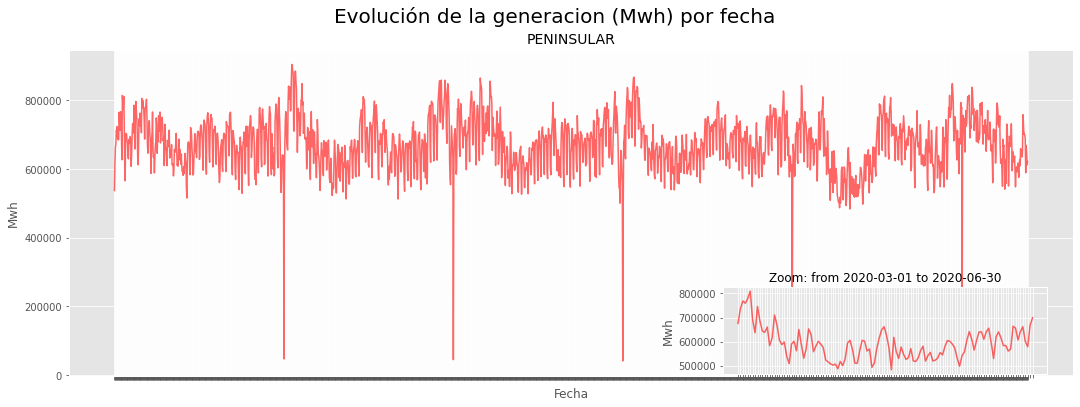

In [80]:
plot_generacion(df_ree_renov,['Generación total'],'peninsular','2020-03-01','2020-06-30')

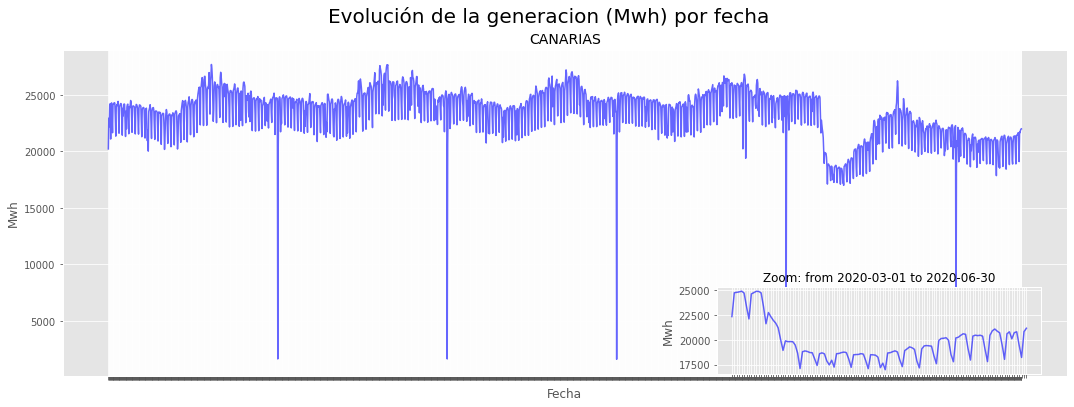

In [81]:
plot_generacion(df_ree_renov,['Generación total'],'canarias','2020-03-01','2020-06-30',c='b')

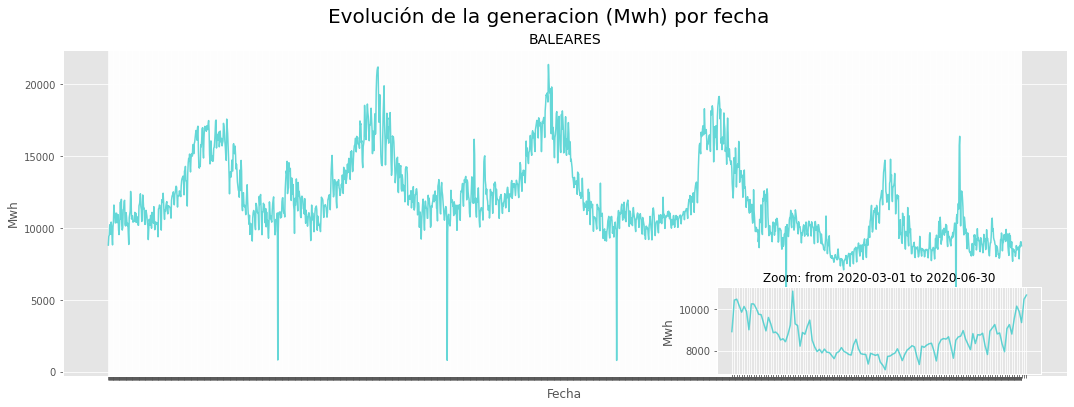

In [82]:
plot_generacion(df_ree_renov,['Generación total'],'baleares','2020-03-01','2020-06-30',c='c')

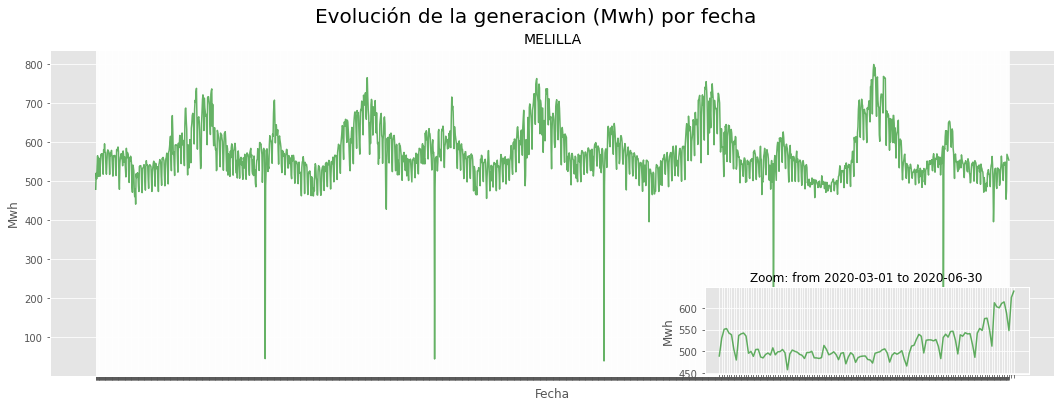

In [83]:
plot_generacion(df_ree_renov,['Generación total'],'melilla','2020-03-01','2020-06-30',c='g')

In [84]:
df_ree_filtered=df_ree_renov[(df_ree_renov['fecha']<'2020-03-15') | (df_ree_renov['fecha']>='2020-06-28')]

In [85]:
df_ree_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72249 entries, 0 to 691
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Generacion_Mwh  72249 non-null  float64
 1   Tecnologia      72249 non-null  object 
 2   Renov_norenov   72249 non-null  object 
 3   system          72249 non-null  object 
 4   fecha           72249 non-null  object 
dtypes: float64(1), object(4)
memory usage: 3.3+ MB


# Weather features analysis

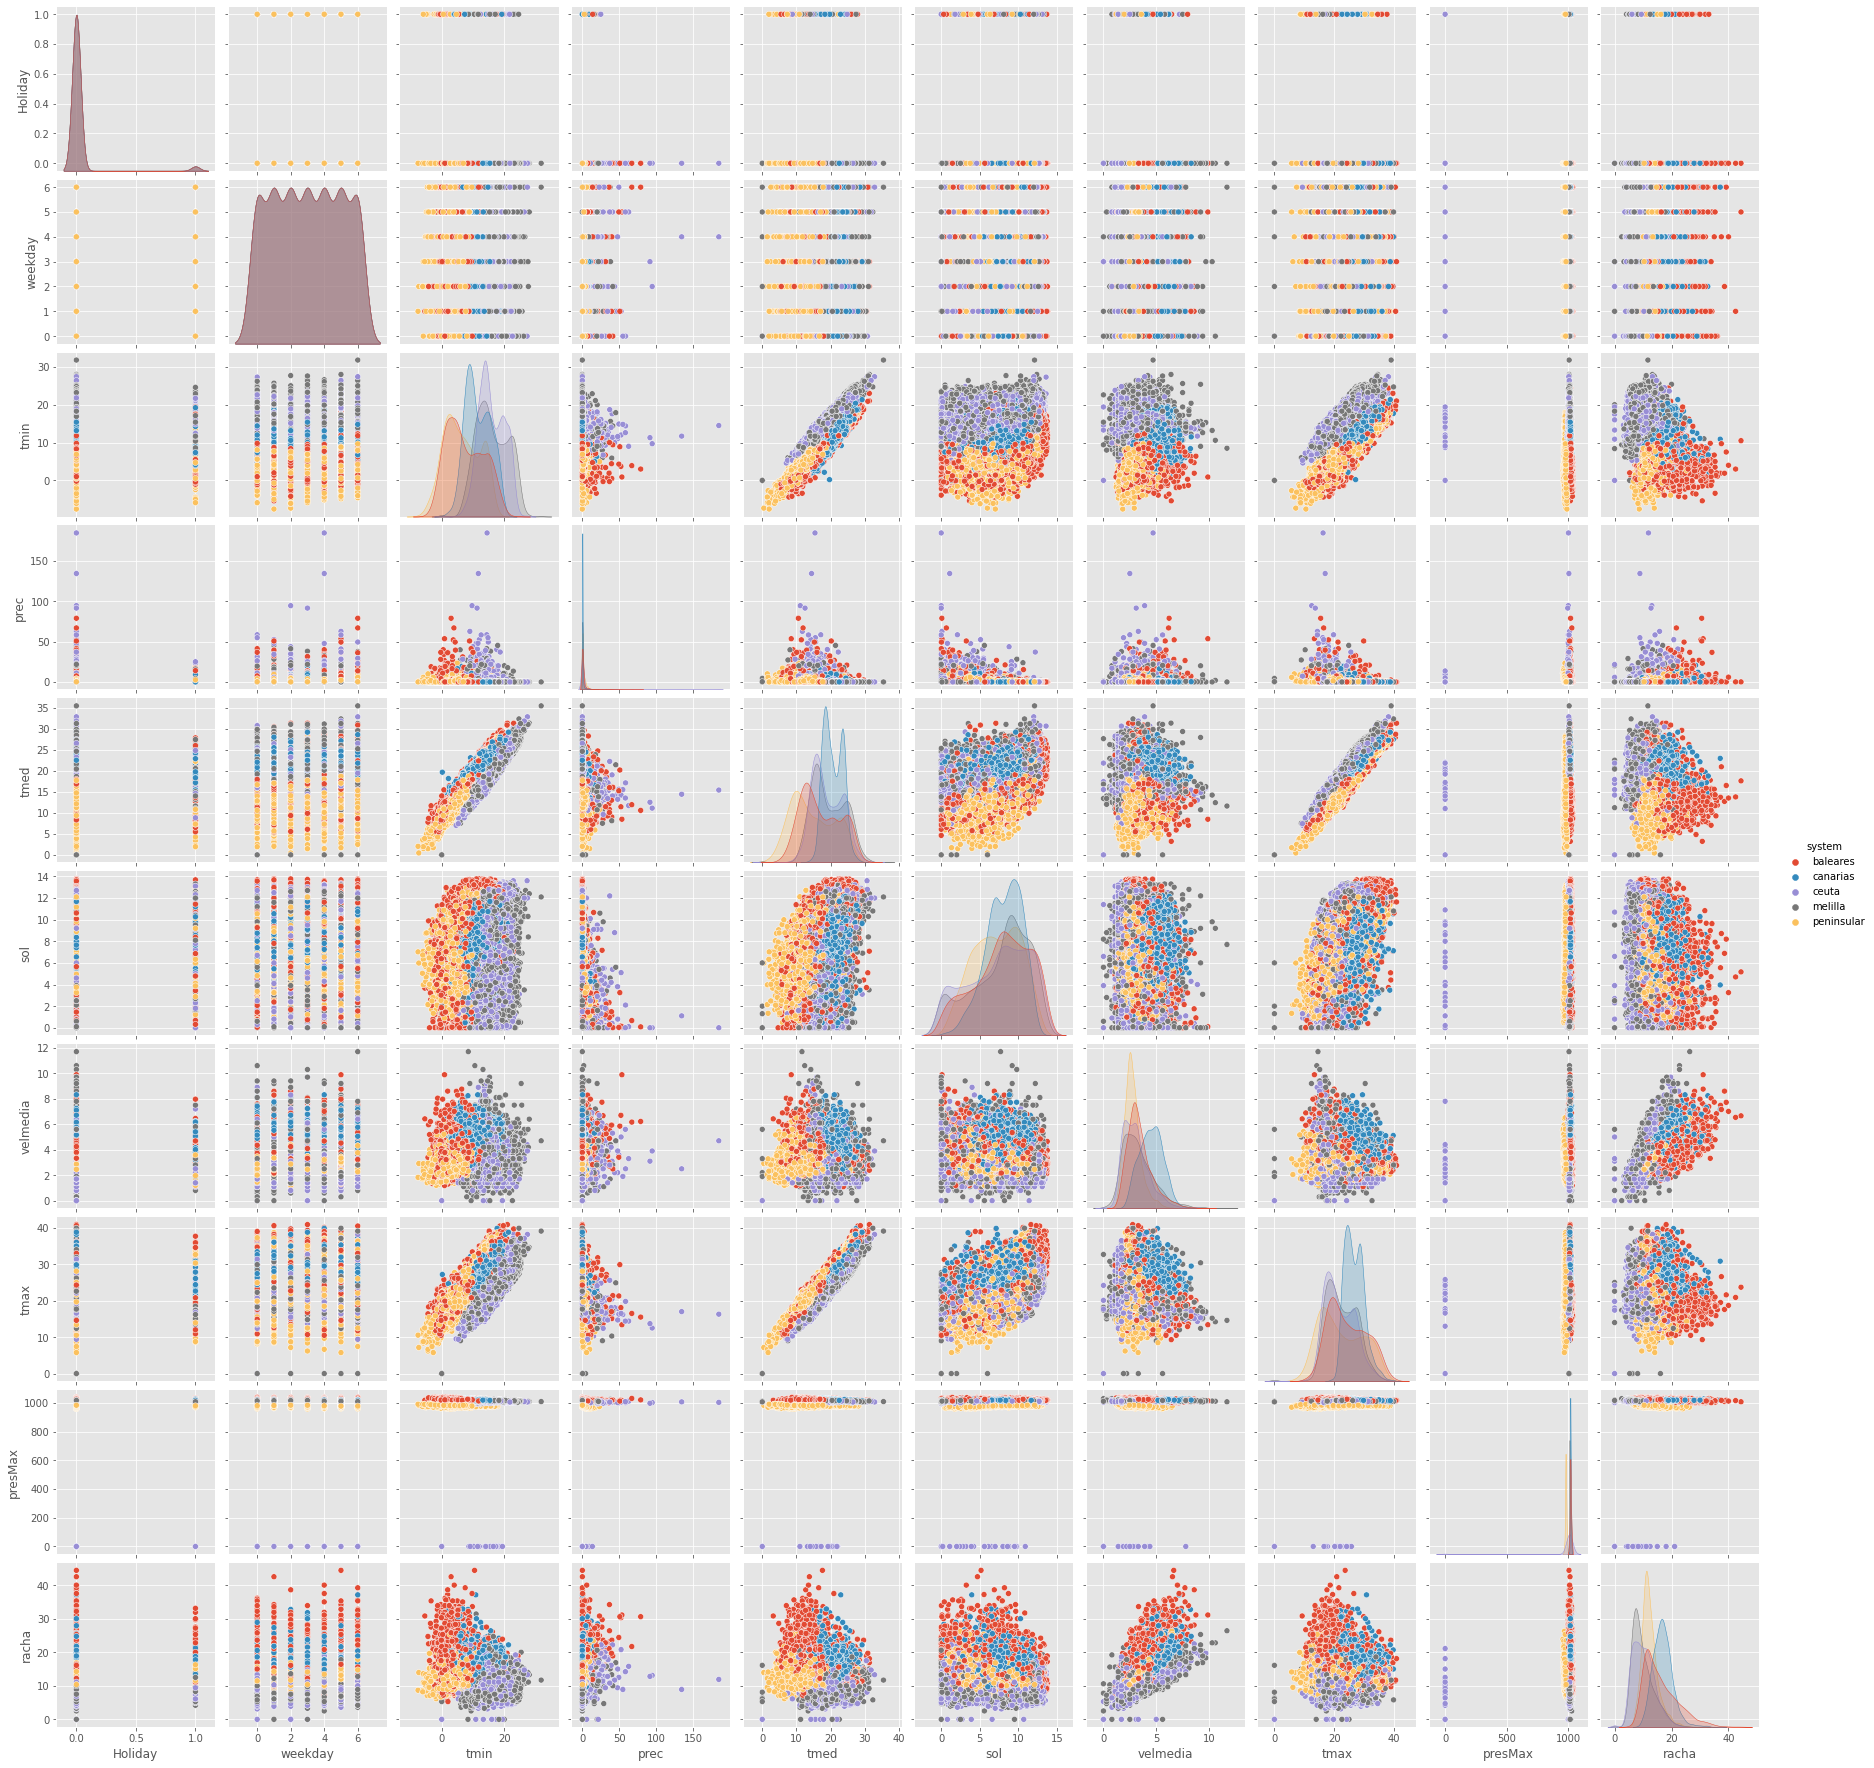

In [86]:
sns.pairplot(data=df_weather_system,hue='system')

Vemos que en funcion de la presion (minima y maxima):
    - Hay 2 grupos muy claramente diferenciandos para temperaturas , velocidad del viento y horas de sol.
    - Y 2 grupos pero no tan claramente diferenciados para las precipitaciones
    - Se ve claramente un dato outlier para precipitaciones y otro para temperatura minima

In [87]:
df_Matrix_Corr=df_weather_system.corr()

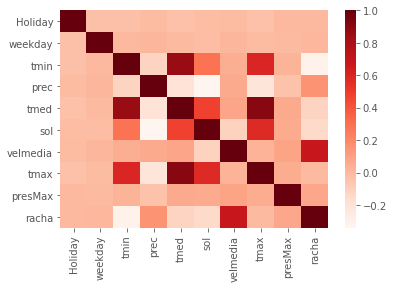

In [88]:
sns.heatmap(df_Matrix_Corr,cmap='Reds');

In [89]:
df_Matrix_Corr

,Holiday,weekday,tmin,prec,tmed,sol,velmedia,tmax,presMax,racha
Holiday,1.000000,-0.023335,-0.024877,-0.010752,-0.030169,-0.015476,-0.006758,-0.030798,0.002061,0.002779
weekday,-0.023335,1.000000,0.000973,0.019362,-0.002294,-0.012065,0.017847,-0.006898,-0.002794,0.012829
tmin,-0.024877,0.000973,1.000000,-0.120387,0.862458,0.291467,0.049870,0.601603,0.023151,-0.312520
prec,-0.010752,0.019362,-0.120387,1.000000,-0.189568,-0.341052,0.063104,-0.212371,-0.035009,0.159895
tmed,-0.030169,-0.002294,0.862458,-0.189568,1.000000,0.476780,0.085938,0.909738,0.063111,-0.119730
sol,-0.015476,-0.012065,0.291467,-0.341052,0.476780,1.000000,-0.105788,0.580247,0.057938,-0.145677
velmedia,-0.006758,0.017847,0.049870,0.063104,0.085938,-0.105788,1.000000,0.026654,0.091829,0.683203
tmax,-0.030798,-0.006898,0.601603,-0.212371,0.909738,0.580247,0.026654,1.000000,0.052896,-0.001571
presMax,0.002061,-0.002794,0.023151,-0.035009,0.063111,0.057938,0.091829,0.052896,1.000000,0.074349
racha,0.002779,0.012829,-0.312520,0.159895,-0.119730,-0.145677,0.683203,-0.001571,0.074349,1.000000


## Precipitacions

In [90]:
df_weather_system['prec'].describe()

count    9835.000000
mean        1.344627
std         4.988961
min         0.000000
25%         0.000000
50%         0.000000
75%         0.469840
max       184.400000
Name: prec, dtype: float64

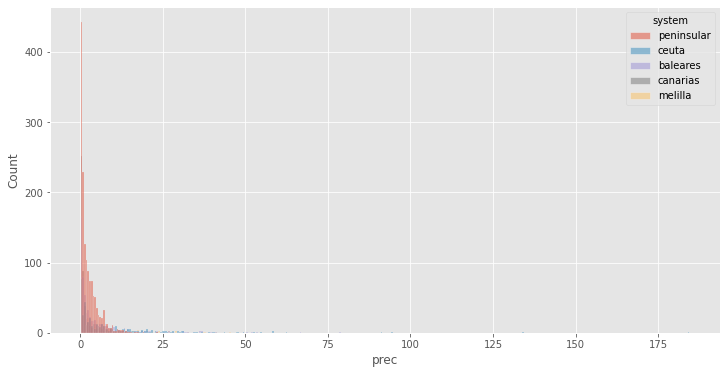

In [91]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.histplot(data=df_weather_system[df_weather_system['prec']>0.1],x='prec',hue='system',alpha=0.5);

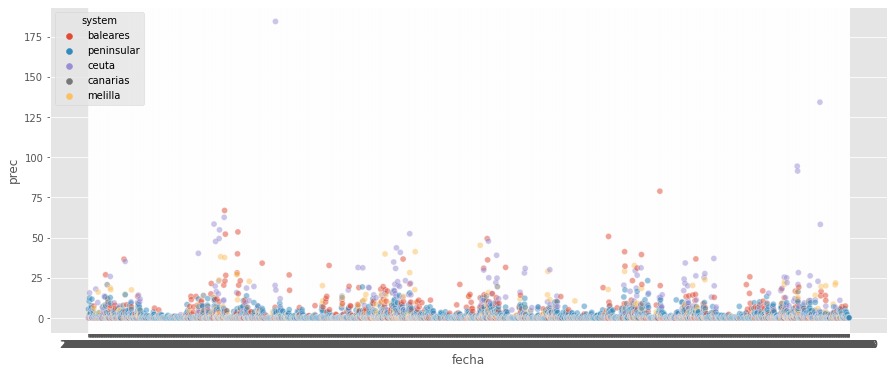

In [92]:
f,ax=plt.subplots(1,1)
f.set_size_inches(15,6)
ax=sns.scatterplot(data=df_weather_system[df_weather_system['prec']>0],y='prec',x='fecha',hue='system',alpha=0.5);

## Hours of sun

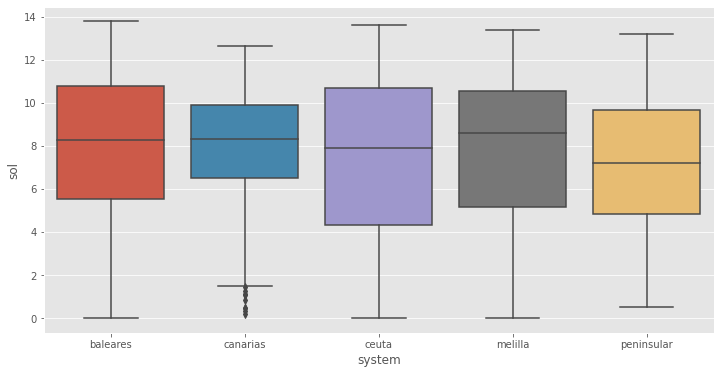

In [93]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='sol', data=df_weather_system);

In [94]:
df_weather_system['sol'].describe()

count    9835.000000
mean        7.638276
std         3.365638
min         0.000000
25%         5.396734
50%         8.100000
75%        10.218083
max        13.783333
Name: sol, dtype: float64

## Temperature

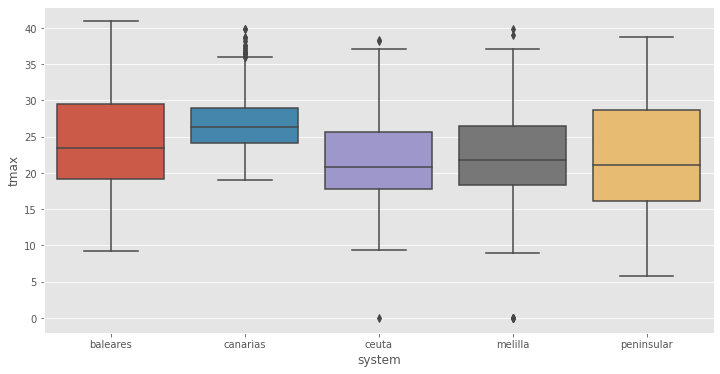

In [95]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='tmax', data=df_weather_system);

In [96]:
df_weather_system['tmax'].describe()

count    9835.000000
mean       23.544238
std         5.880353
min         0.000000
25%        18.800000
50%        23.600000
75%        27.900000
max        40.900000
Name: tmax, dtype: float64

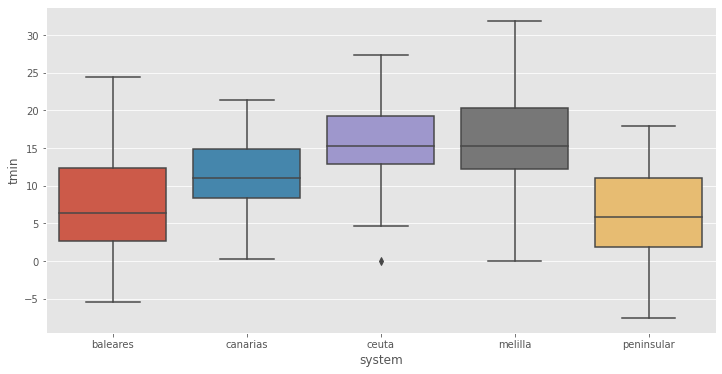

In [97]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='tmin', data=df_weather_system);

In [98]:
df_weather_system['tmin'].describe()

count    9835.000000
mean       11.456148
std         6.372629
min        -7.570213
25%         7.150000
50%        12.000000
75%        15.750000
max        31.800000
Name: tmin, dtype: float64

## Wind

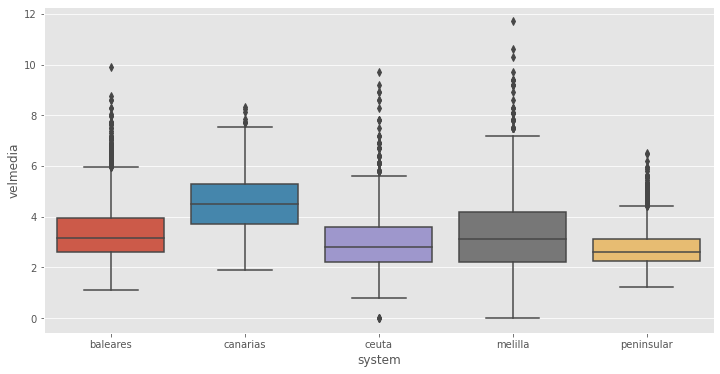

In [99]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='velmedia', data=df_weather_system);

In [100]:
df_weather_system['velmedia'].describe()

count    9835.000000
mean        3.391617
std         1.335338
min         0.000000
25%         2.462514
50%         3.100000
75%         4.200000
max        11.700000
Name: velmedia, dtype: float64

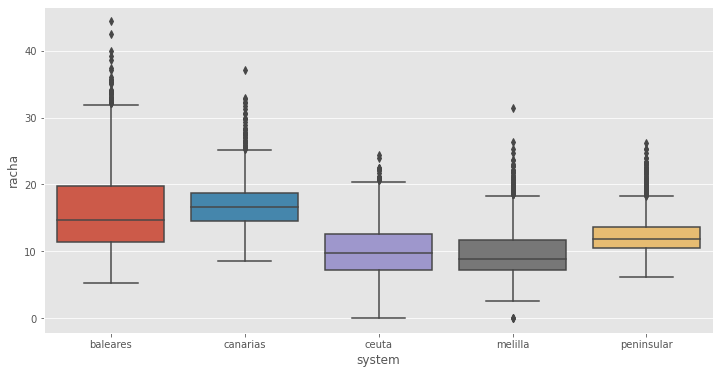

In [101]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='racha', data=df_weather_system);

In [102]:
df_weather_system['racha'].describe()

count    9835.000000
mean       13.009341
std         5.044742
min         0.000000
25%         9.526596
50%        12.200000
75%        16.011702
max        44.400000
Name: racha, dtype: float64

# Outliers

Vamos a buscar los outlier de precipitaciones y temperatura minima, por si fuesen datos erroneos.



### Outlier de Precipitaciones


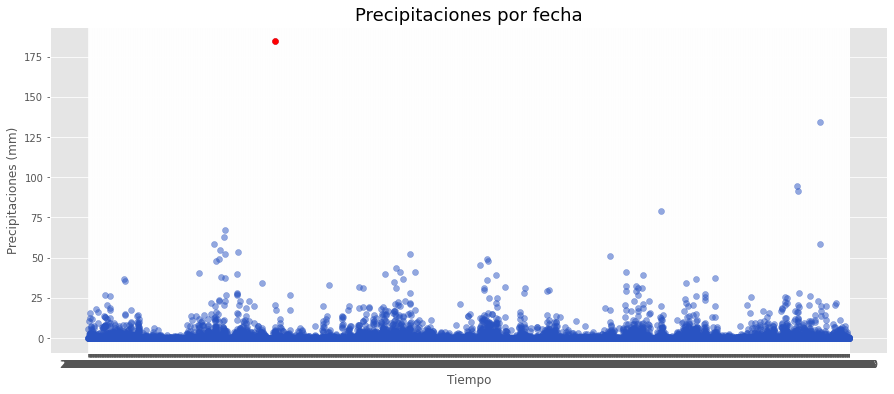

In [103]:

maxprec_mm=df_weather_system[df_weather_system['prec']==df_weather_system['prec'].max()]['prec']
maxprec_fec=df_weather_system[df_weather_system['prec']==df_weather_system['prec'].max()]['fecha']
plt.figure(figsize=(15,6))
plt.scatter(df_weather_system['fecha'],df_weather_system['prec'],c='#2953C2',alpha=0.5)
plt.scatter(maxprec_fec,maxprec_mm,c='r')
plt.title('Precipitaciones por fecha',fontsize=18)
plt.xlabel('Tiempo')
plt.ylabel('Precipitaciones (mm)')
plt.minorticks_off();


In [104]:
df_weather_system[df_weather_system['prec']==df_weather_system['prec'].max()]

,fecha,system,Holiday,weekday,tmin,prec,tmed,sol,velmedia,tmax,presMax,racha
2417,2017-04-28,ceuta,0,4,14.5,184.4,15.4,0.0,4.7,16.3,1002.7,11.9


### Outliers de Temperatura mínima

El 02-08-2020 tenemos un dato máximo en la serie histórica de temperaturas minimas de 31,8 grados en la estación de MELILLA

In [105]:
tminGrouped=df_weather_system.groupby('fecha')['tmin'].mean().reset_index()
maxtmin_celsius=df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].max()]['tmin']
maxtmin_fec=df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].max()]['fecha']
mintmin_celsius=df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].min()]['tmin']
mintmin_fec=df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].min()]['fecha']

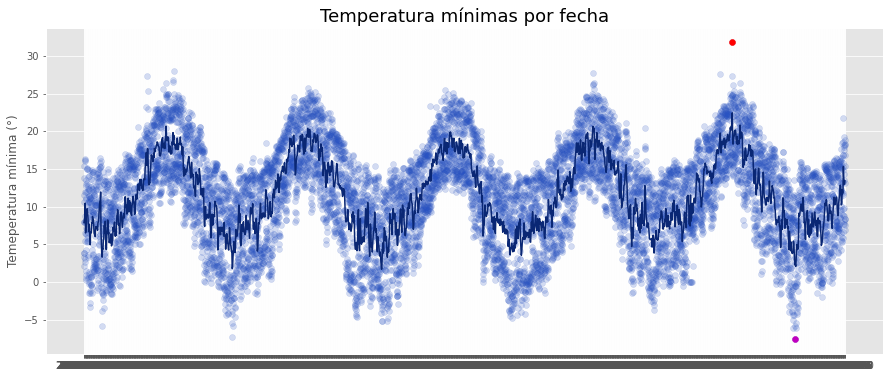

In [106]:

plt.figure(figsize=(15,6))
plt.plot(tminGrouped['fecha'],tminGrouped['tmin'],c='#0A2774')
plt.scatter(df_weather_system['fecha'],df_weather_system['tmin'],c='#2953C2',alpha=0.2)
plt.scatter(maxtmin_fec,maxtmin_celsius,c='r')
plt.scatter(mintmin_fec,mintmin_celsius,c='m')
plt.title('Temperatura mínimas por fecha',fontsize=18)
plt.ylabel('Tiempo')
plt.ylabel('Temeperatura mínima (°)');



In [107]:
df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].max()]

,fecha,system,Holiday,weekday,tmin,prec,tmed,sol,velmedia,tmax,presMax,racha
8378,2020-08-02,melilla,0,6,31.8,0.0,35.4,12.1,4.7,39.1,1008.3,11.7


In [108]:
df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].min()]

,fecha,system,Holiday,weekday,tmin,prec,tmed,sol,velmedia,tmax,presMax,racha
9194,2021-01-12,peninsular,0,1,-7.570213,0.022589,2.022069,7.020053,1.827664,10.544681,989.948936,8.670213


### Outliers de Temperatura máxima

In [109]:
tmaxGrouped=df_weather_system.groupby('fecha')['tmax'].mean().reset_index()
maxtmax_celsius=df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].max()]['tmax']
maxtmax_fec=df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].max()]['fecha']
mintmax_celsius=df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].min()]['tmax']
mintmax_fec=df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].min()]['fecha']

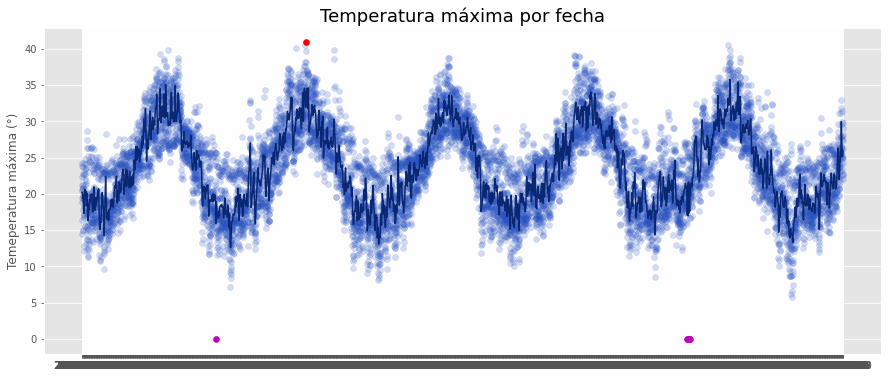

In [110]:
plt.figure(figsize=(15,6))
plt.plot(tmaxGrouped['fecha'],tmaxGrouped['tmax'],c='#0A2774')
plt.scatter(df_weather_system['fecha'],df_weather_system['tmax'],c='#2953C2',alpha=0.2)
plt.scatter(maxtmax_fec,maxtmax_celsius,c='r')
plt.scatter(mintmax_fec,mintmax_celsius,c='m')
plt.title('Temperatura máxima por fecha',fontsize=18)
plt.ylabel('Tiempo')
plt.ylabel('Temeperatura máxima (°)');


In [111]:
df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].max()]

,fecha,system,Holiday,weekday,tmin,prec,tmed,sol,velmedia,tmax,presMax,racha
2900,2017-08-03,baleares,0,3,21.0,0.0,31.28,11.633333,2.77,40.9,1016.4,18.1


In [112]:
df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].min()]

,fecha,system,Holiday,weekday,tmin,prec,tmed,sol,velmedia,tmax,presMax,racha
1732,2016-12-12,ceuta,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7823,2020-04-13,melilla,0,0,0.0,1.0,0.0,2.0,1.9,0.0,1005.6,6.4
7833,2020-04-15,melilla,0,2,0.0,0.0,0.0,6.0,3.3,0.0,1011.8,8.1
7843,2020-04-17,melilla,0,4,0.0,0.0,0.0,0.0,2.2,0.0,1010.8,6.1
7848,2020-04-18,melilla,0,5,0.0,4.4,0.0,0.0,1.9,0.0,1009.1,5.3
7853,2020-04-19,melilla,0,6,0.0,0.4,0.0,1.3,5.6,0.0,1006.2,16.1


#Save to pickle

In [113]:
df_weather_system.to_pickle(Ing_AEMET.path_Data+"Weather_df.pkl")

In [114]:
df_ree_filtered.to_pickle(Ing_AEMET.path_Data+"Ree_df.pkl")